In [1]:
import dotenv
import os

dotenv.load_dotenv(dotenv_path="secrets.env")
hf_token = os.getenv("HUGGINGFACE_API_KEY")

import os

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import dotenv

from tasks.hp.HPTask import HPTriviaTask, HPVerbatimTask, HPVerbatimTaskTranchedByBook
from tasks.hp.HPSAQ import HPSAQ, HPSAQTranchedByBook
from tasks.hp.HPFamiliarity import HPCompletionsFamiliarity, HPFamiliarityTranchedByBook

from datetime import datetime

import tqdm
import torch

import matplotlib.pyplot as plt

plt.style.use('plot_style.txt')

pallet = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

In [2]:
def load_ckpt(base_model, folder, ckpt):
    peft_model = PeftModel.from_pretrained(base_model, os.path.join(folder, "checkpoint-" + str(ckpt)))
    return peft_model

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/Llama2-7b-WhoIsHarryPotter",
    use_auth_token=hf_token
)

tokenizer.pad_token = tokenizer.eos_token

print(tokenizer.pad_token)

# def check_familiarity(model, steer_layer, use_short=False, model_name=None, **kwargs):
    
#     hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts_short.json' if use_short else 'tasks/hp/data/msr_data/evaluation_prompts.json')
#     model_fn = lambda input: steer_inference_fn(input, model, layer=steer_layer, strength=strength, **kwargs)

#     if save_gens:
#         exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
#         save_path_fn = lambda model_name: f'temp_gens/{eval_model}-{use_short=}-familiarity-completions-evaluated-{exp_time}.jsonl'
#     else:
#         save_path_fn = lambda model_name: None

#     hp_familiarity_task.generate_responses(model_fn, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=False, max_new_tokens=20, temperature=0, verbose=True, batch_size=20)
#     hp_familiarity_task.run_model_evals(eval_model=eval_model, max_eval_tokens=None, save_path=save_path_fn(model_name), batch_size=20)
#     familiarity, responses = hp_familiarity_task.get_accuracies()
#     return familiarity, responses

def eval_model(model):    
    hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts.json')
    hp_familiarity_task.generate_responses(model, tokenizer, save_path=None, eval_onthe_fly=False, max_new_tokens=20, do_sample=False, verbose=True, batch_size=20)
    hp_familiarity_task.run_model_evals(eval_model="gpt-4-turbo-preview", max_eval_tokens=None, save_path=None, batch_size=20)
    familiarity, responses = hp_familiarity_task.get_accuracies()
    print(responses)
    return familiarity

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:711: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


</s>


In [4]:
# model_ckpts = [200, 400, 600, 800, 1000]
model_ckpts = [100, 1000]
model_folders = ["verbatim_finetune", "verbatim_finetune_base"]

base_models = ["hp-unlrn", "llama"]

llama_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    use_auth_token=hf_token,
    torch_dtype=torch.bfloat16
).cuda()

base_acc = eval_model(llama_model)

del llama_model

hp_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Llama2-7b-WhoIsHarryPotter",
    use_auth_token=hf_token,
    torch_dtype=torch.bfloat16
).cuda()

tokenizer.pad_token = tokenizer.eos_token

hp_acc = eval_model(hp_model)

del hp_model

all_accuracies = []

for model_folder, base_model in zip(model_folders, base_models):
    if base_model == "llama":
        accuracies = [(0, base_acc)]

        base_model = AutoModelForCausalLM.from_pretrained(
            "meta-llama/Llama-2-7b-chat-hf",
            use_auth_token=hf_token,
            torch_dtype=torch.bfloat16
        ).cuda()
    else:
        accuracies = [(0, hp_acc)]

        base_model = AutoModelForCausalLM.from_pretrained(
            "microsoft/Llama2-7b-WhoIsHarryPotter",
            use_auth_token=hf_token,
            torch_dtype=torch.bfloat16
        ).cuda()
    
    for ckpt in model_ckpts:
        print(ckpt)
        adapter = load_ckpt(base_model, model_folder, ckpt)
        acc = eval_model(base_model)
        accuracies.append((ckpt, acc))
        adapter.unload()
    
    all_accuracies.append(accuracies)

    del base_model

print(base_acc)
print(hp_acc)
print(all_accuracies)

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing questions 0 to 20 of 300


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:407: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 20 to 40 of 300
Processing questions 40 to 60 of 300
Processing questions 60 to 80 of 300
Processing questions 80 to 100 of 300
Processing questions 100 to 120 of 300
Processing questions 120 to 140 of 300
Processing questions 140 to 160 of 300
Processing questions 160 to 180 of 300
Processing questions 180 to 200 of 300
Processing questions 200 to 220 of 300
Processing questions 220 to 240 of 300
Processing questions 240 to 260 of 300
Processing questions 260 to 280 of 300
Processing questions 280 to 300 of 300


  7%|█████████▌                                                                                                                                      | 1/15 [00:37<08:38, 37.06s/it]

Error in getting model grade, returning -100


 13%|███████████████████▏                                                                                                                            | 2/15 [01:26<09:34, 44.22s/it]

Error in getting model grade, returning -100
Error in getting model grade, returning -100


 33%|████████████████████████████████████████████████                                                                                                | 5/15 [03:17<06:29, 38.97s/it]

Error in getting model grade, returning -100


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 10/15 [06:37<03:14, 38.82s/it]

Error in getting model grade, returning -100


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 12/15 [07:59<02:02, 40.73s/it]

Error in getting model grade, returning -100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [09:43<00:00, 38.89s/it]
300it [00:00, 482103.91it/s]
/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


defaultdict(<class 'int'>, {2: 46, 3: 111, 0: 96, 1: 41, -100: 6})


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Processing questions 0 to 20 of 300


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:407: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 20 to 40 of 300
Processing questions 40 to 60 of 300
Processing questions 60 to 80 of 300
Processing questions 80 to 100 of 300
Processing questions 100 to 120 of 300
Processing questions 120 to 140 of 300
Processing questions 140 to 160 of 300
Processing questions 160 to 180 of 300
Processing questions 180 to 200 of 300
Processing questions 200 to 220 of 300
Processing questions 220 to 240 of 300
Processing questions 240 to 260 of 300
Processing questions 260 to 280 of 300
Processing questions 280 to 300 of 300


  7%|█████████▌                                                                                                                                      | 1/15 [00:34<08:05, 34.66s/it]

Error in getting model grade, returning -100


 33%|████████████████████████████████████████████████                                                                                                | 5/15 [02:53<06:02, 36.27s/it]

Error in getting model grade, returning -100


 40%|█████████████████████████████████████████████████████████▌                                                                                      | 6/15 [03:28<05:21, 35.71s/it]

Error in getting model grade, returning -100


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 11/15 [06:19<02:16, 34.10s/it]

Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 12/15 [06:58<01:46, 35.64s/it]

Error in getting model grade, returning -100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [08:39<00:00, 34.66s/it]
300it [00:00, 265182.55it/s]


defaultdict(<class 'int'>, {2: 35, 0: 174, 3: 28, 1: 54, -100: 9})
100
Processing questions 0 to 20 of 300
Processing questions 20 to 40 of 300
Processing questions 40 to 60 of 300
Processing questions 60 to 80 of 300
Processing questions 80 to 100 of 300
Processing questions 100 to 120 of 300
Processing questions 120 to 140 of 300
Processing questions 140 to 160 of 300
Processing questions 160 to 180 of 300
Processing questions 180 to 200 of 300
Processing questions 200 to 220 of 300
Processing questions 220 to 240 of 300
Processing questions 240 to 260 of 300
Processing questions 260 to 280 of 300
Processing questions 280 to 300 of 300


  0%|                                                                                                                                                        | 0/15 [00:00<?, ?it/s]

Error in getting model grade, returning -100


  7%|█████████▌                                                                                                                                      | 1/15 [00:31<07:26, 31.87s/it]

Error in getting model grade, returning -100


 33%|████████████████████████████████████████████████                                                                                                | 5/15 [02:53<05:49, 34.98s/it]

Error in getting model grade, returning -100


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 11/15 [06:49<02:32, 38.13s/it]

Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 13/15 [07:59<01:13, 36.83s/it]

Error in getting model grade, returning -100


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 14/15 [08:33<00:36, 36.17s/it]

Error in getting model grade, returning -100
Error in getting model grade, returning -100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [09:11<00:00, 36.74s/it]
300it [00:00, 431957.16it/s]


defaultdict(<class 'int'>, {1: 47, 0: 186, 3: 28, -100: 10, 2: 29})


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100
Processing questions 0 to 20 of 300


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Processing questions 20 to 40 of 300
Processing questions 40 to 60 of 300
Processing questions 60 to 80 of 300
Processing questions 80 to 100 of 300
Processing questions 100 to 120 of 300
Processing questions 120 to 140 of 300
Processing questions 140 to 160 of 300
Processing questions 160 to 180 of 300
Processing questions 180 to 200 of 300
Processing questions 200 to 220 of 300
Processing questions 220 to 240 of 300
Processing questions 240 to 260 of 300
Processing questions 260 to 280 of 300
Processing questions 280 to 300 of 300


 20%|████████████████████████████▊                                                                                                                   | 3/15 [01:59<08:09, 40.77s/it]

Error in getting model grade, returning -100


 40%|█████████████████████████████████████████████████████████▌                                                                                      | 6/15 [03:46<05:33, 37.02s/it]

Error in getting model grade, returning -100


 53%|████████████████████████████████████████████████████████████████████████████▊                                                                   | 8/15 [04:58<04:13, 36.21s/it]

In [ ]:
# print("base_acc =", base_acc)
# print("hp_acc =", hp_acc)
# print("all_accuracies =", all_accuracies)

In [ ]:
# results for finetuned unlearned and chat models - FOR PAPER
base_acc = 3.036888837814331
hp_acc = 3.4972031116485596
all_accuracies = [[(0, 3.4972031116485596), (100, 3.28092622756958), (200, 3.0460121631622314), (300, 2.9241957664489746), (400, 2.8950257301330566), (500, 2.885110378265381), (600, 2.8738954067230225), (700, 2.8775532245635986), (800, 2.8754568099975586), (900, 2.8759214878082275), (1000, 2.8729376792907715)], [(0, 3.036888837814331), (100, 2.908545970916748), (200, 2.792257070541382), (300, 2.7728617191314697), (400, 2.762115955352783), (500, 2.7416458129882812), (600, 2.7486376762390137), (700, 2.746772050857544), (800, 2.7435569763183594), (900, 2.751146078109741), (1000, 2.750664472579956)]]

In [ ]:
# results from prev run
base_acc_ = 0.46534305908678647
hp_acc_ = 0.32427038263675156
all_accuracies_ = [[(0, 0.32427038263675156), (100, 0.32125954361627784), (200, 0.35320556782193674), (300, 0.3950250996178836), (400, 0.3963737045958042), (500, 0.42296944927665525), (600, 0.49241389372109967), (700, 0.44076731789999557), (800, 0.5259048314673566), (900, 0.4175018492498922), (1000, 0.41718241223961816)]]

In [ ]:
base_acc_ = 0.22818220519369947
hp_acc_ = 0.10280970625798212
all_accuracies_ = [[(0, 0.10280970625798212), (100, 0.1336739037888463), (200, 0.09450830140485313), (300, 0.24244359301830565), (400, 0.2220093656875266), (500, 0.15197956577266922), (600, 0.18284376330353344), (700, 0.13154533844189017), (800, 0.09663686675180927), (900, 0.1911451681566624), (1000, 0.12537249893571734)]]

In [ ]:
# results on cross-entropy eval (1000 samples from books 4-7)
base_acc_ = 3.0362651348114014
hp_acc_ = 3.502548933029175
all_accuracies_ = [[(0, 3.502548933029175), (100, 3.2807469367980957), (200, 3.0449798107147217), (300, 2.9233744144439697), (400, 2.895801305770874), (500, 2.881465196609497), (600, 2.87931227684021), (700, 2.8763437271118164), (800, 2.8760416507720947), (900, 2.872117757797241), (1000, 2.8754565715789795)]]

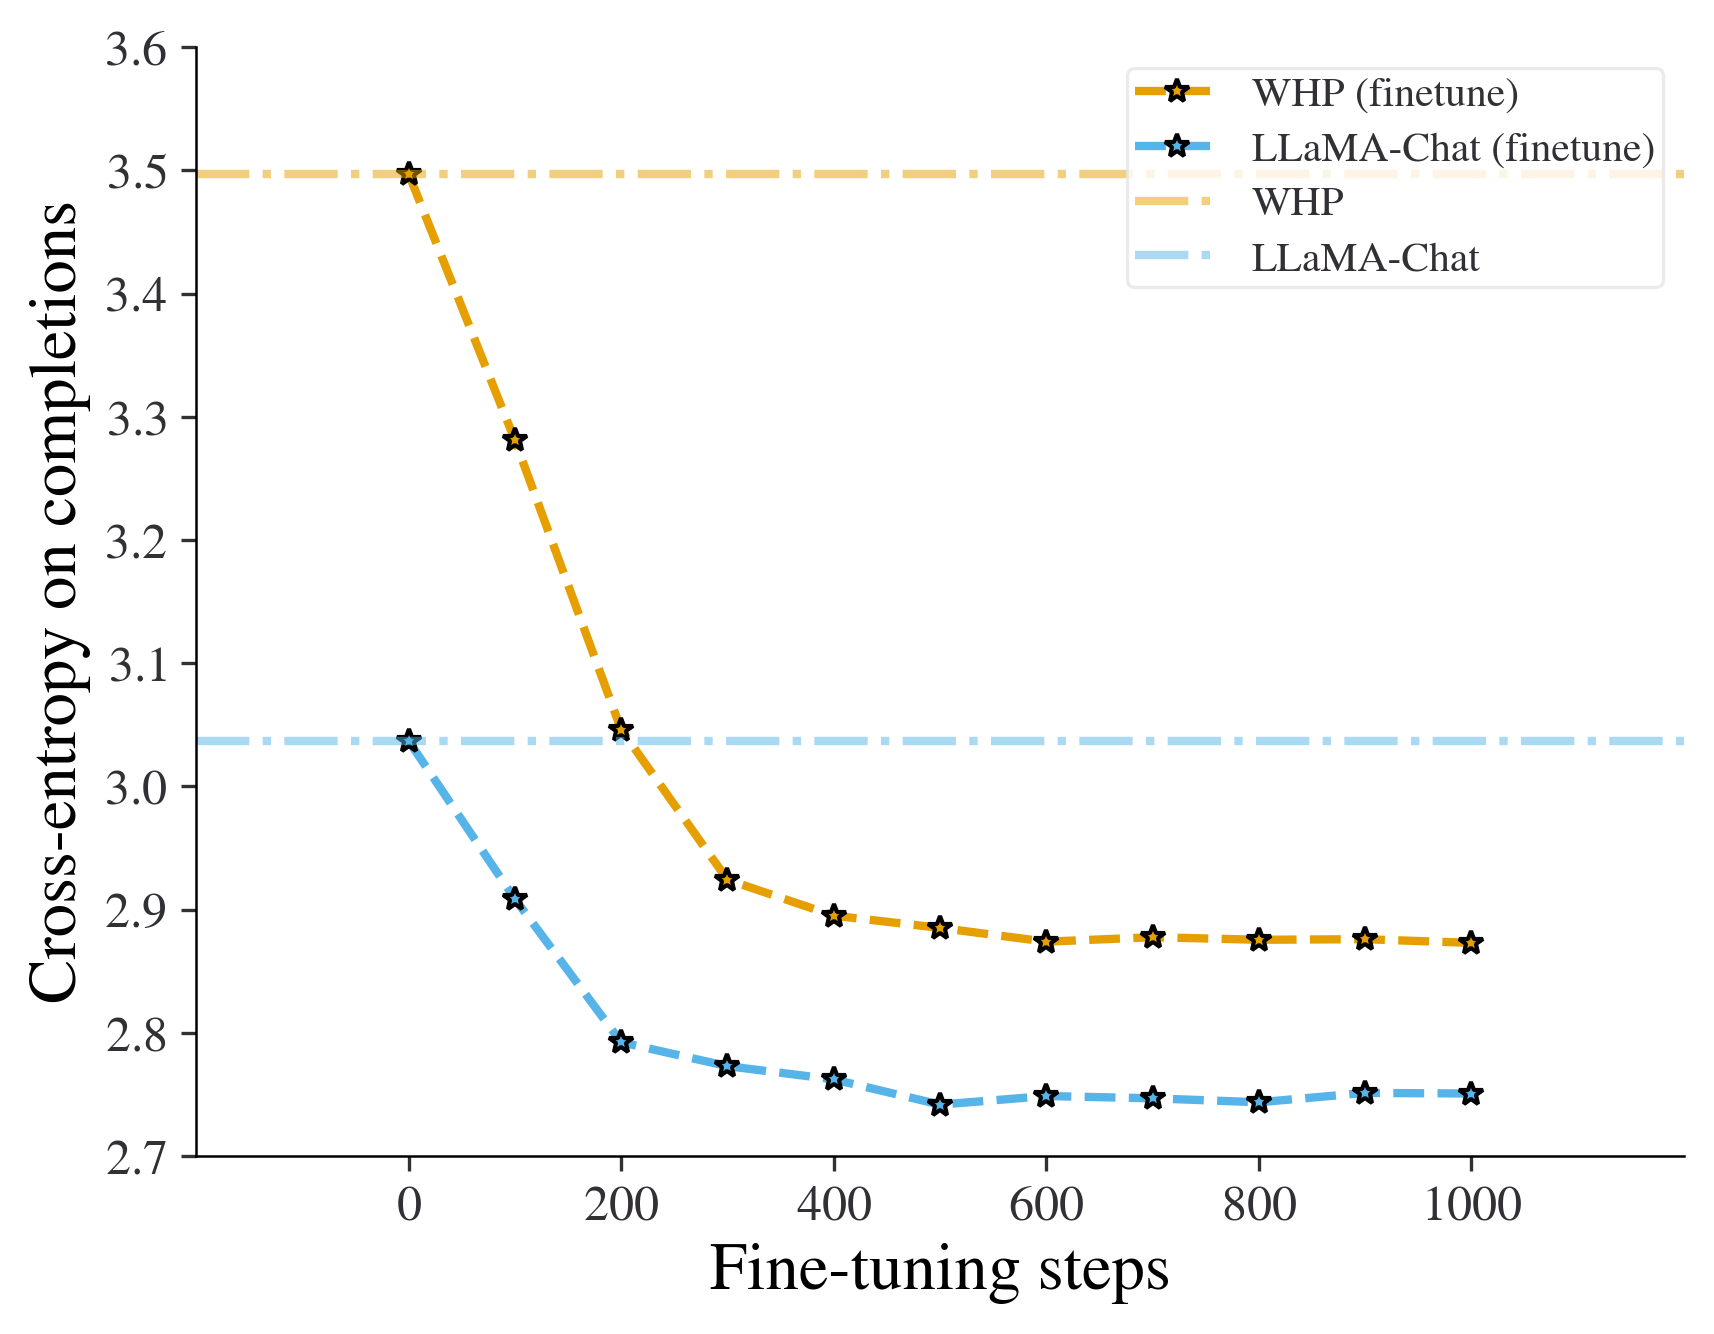

In [ ]:
keys = ["zero_shot"]
line_styles = ['--', '-', '-.']

#for y, key in zip(ys, keys):
#    plt.plot(x, y, linestyle="--", marker="*", label="dpo_" + key)

labels = ["WHP (finetune)", "LLaMA-Chat (finetune)"]
colors = [pallet[1], pallet[2]]

for accs, label, color in zip(all_accuracies, labels, colors):
    xs = [ckpt for ckpt, _ in accs]
    ys = [acc for _, acc in accs]
    plt.plot(xs, ys, linestyle="--", marker="*", label=label, color=color)

plt.xlabel('Fine-tuning steps', fontsize=16)
plt.ylabel('Cross-entropy on completions', fontsize=16)

#for key, line_style in zip(keys, line_styles):
#    plt.axhline(y=base_acc[key], color='r', linestyle=line_style, label="base_" + key)
#    plt.axhline(y=hp_acc[key], color='g', linestyle=line_style, label="unlearned_" + key)

plt.axhline(y=hp_acc, linestyle='-.', label="WHP", alpha=0.5, color=colors[0])
plt.axhline(y=base_acc, linestyle='-.', label="LLaMA-Chat", alpha=0.5, color=colors[1])

plt.legend(loc="upper right")

plt.xticks(ticks=[0, 200, 400, 600, 800, 1000])

plt.savefig("ft_comparison.svg", format="svg")

In [ ]:
# hp_model = AutoModelForCausalLM.from_pretrained(
#     "microsoft/Llama2-7b-WhoIsHarryPotter",
#     use_auth_token=hf_token,
#     torch_dtype=torch.bfloat16
# ).cuda()

In [ ]:
# few_shot_counts = [10, 8, 6, 4, 2, 0]

# unlearned_model_points = []

# for count in few_shot_counts:
#     with torch.no_grad(), torch.autocast(device_type="cuda"):
#         hp_verbatim_task = HPVerbatimTaskTranchedByBook(16, tokenizer, books_to_test_on, few_shot_num=count, few_shot_book_ids=[1, 2, 3])
#         acc = hp_verbatim_task.get_test_loss(hp_model, n_iters=500).item()
#         print(f"few_shot_count={count}, acc={acc}")
#         unlearned_model_points.append((count, acc))

In [ ]:
# del hp_model

# llama_model = AutoModelForCausalLM.from_pretrained(
#     "meta-llama/Llama-2-7b-chat-hf",
#     use_auth_token=hf_token,
#     torch_dtype=torch.bfloat16
# ).cuda()

In [ ]:
# llama_model_points = []

# for count in few_shot_counts:
#     with torch.no_grad(), torch.autocast(device_type="cuda"):
#         hp_verbatim_task = HPVerbatimTaskTranchedByBook(16, tokenizer, books_to_test_on, few_shot_num=count, few_shot_book_ids=[1, 2, 3])
#         acc = hp_verbatim_task.get_test_loss(hp_model, n_iters=100).item()
#         print(f"few_shot_count={count}, acc={acc}")
#         llama_model_points.append((count, acc))

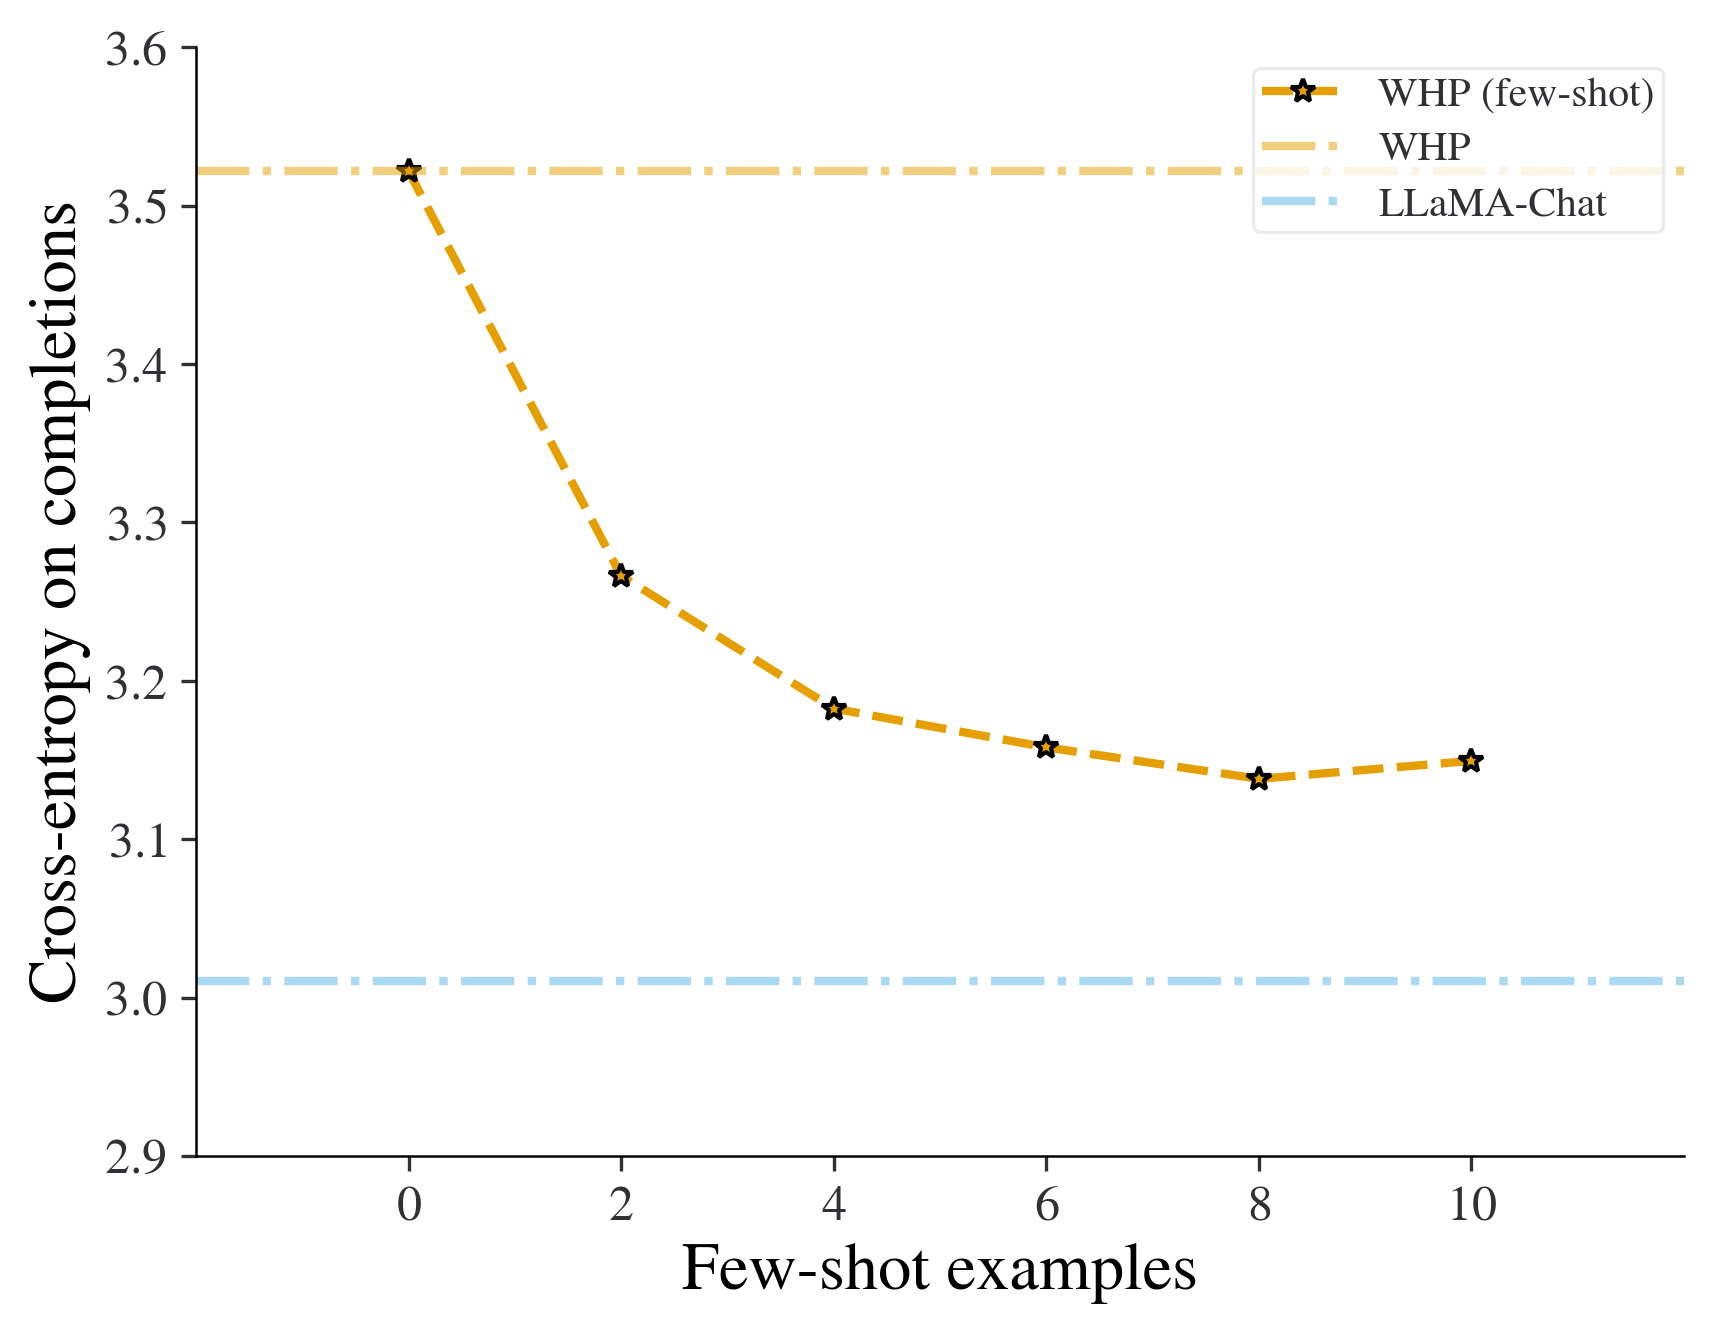

In [ ]:
import pandas as pd

# Load the first CSV file
df1 = pd.read_csv('icl_data_results.csv')
x1 = df1['x']
y1 = df1['y']

# Load the second CSV file
df2 = pd.read_csv('icl_data_results_llama.csv')
x2 = df2['x']
y2 = df2['y']

# Plot the data
plt.plot(x1, y1, label='WHP (few-shot)', linestyle='--', marker='*', color=colors[0])
# plt.plot(x2, y2, label='LLaMA-Chat', linestyle='--', marker='*')

plt.axhline(y=y1[len(y1)-1], linestyle='-.', label="WHP", color=colors[0], alpha=0.5)
plt.axhline(y=y2[len(y2)-1], linestyle='-.', label="LLaMA-Chat", color=colors[1], alpha=0.5)

# Add labels and legend
plt.xlabel('Few-shot examples', fontsize=16)
plt.ylabel('Cross-entropy on completions', fontsize=16)
plt.legend(loc="upper right")

plt.xticks(ticks=[0, 2, 4, 6, 8, 10])

# Show the plot
plt.savefig("icrl.svg", format="svg")
